# Reinforcement Learning in Finite MDPs

In [0]:
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1

## MDPs

In [0]:
import sys
sys.path.insert(0, './mvarl_hands_on/utils')
import numpy as np
from scipy.special import softmax # for SARSA
import matplotlib.pyplot as plt
import json
import math
from cliffwalk import CliffWalk
from test_env import ToyEnv1

Setting up the environment

In [52]:
env = CliffWalk(proba_succ=0.98)

####################################################################################
# You probably want to test smaller enviroments before
#env = ToyEnv1(gamma=0.95)
####################################################################################

# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s, a, s'] = env.P[s, a, s']
print("R has shape: ", env.R.shape)
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=1, a=3,s'=2): ", env.reward_func(1,3,2))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward, done, info)
    if done:
        break
    state = next_state
print("")

next_state, reward, done, info = env.step(1)

Set of states: range(0, 48)
Set of actions: [0, 1, 2, 3]
Number of states:  48
Number of actions:  4
P has shape:  (48, 4, 48)
R has shape:  (48, 4, 48)
discount factor:  0.99

initial state:  36
reward at (s=1, a=3,s'=2):  0.6

random policy =  [1 1 0 1 2 0 2 1 2 0 3 3 2 1 2 1 2 1 0 0 0 1 3 1 2 0 3 3 3 0 1 1 0 3 3 1 1
 3 2 2 3 0 0 3 3 2 1 3]
(s, a, s', r):
36 1 36 0.6 False {}
36 1 36 0.6 False {}
36 1 36 0.6 False {}
36 1 36 0.6 False {}



In [53]:
next_state

36

## Question 1: Value iteration
1. Write a function applying the optimal Bellman operator on a provided Q function: $Q_1 = LQ_0, \; Q_0\in \mathbb{R}^{S\times A}$
2. Write a function implementing Value Iteration (VI) with $\infty$-norm stopping condition (reuse function implemented in 1)
3. Evaluate the convergence of your estimate, i.e., plot the value $\|V_n - V^\star\|_{\infty}$

In [0]:
## In case of 3 dimentional reward matrix
def reward_action(s, a, R, P, Ns):
  sol = 0
  for i in range(Ns):
    sol += R[s,a,i] * P[s,a,i]
  return sol

In [0]:
# --------------
# Point 1
# --------------
def bellman_operator(Q0, Ns, Na, R, P, gamma):
  if len(R.shape) == 3:
    Reward_Matrix = np.zeros((Ns, Na))
    for i in range(Ns):
      for j in range(Na):
        Reward_Matrix[i,j] = reward_action(i,j,R,P,Ns)
    R = Reward_Matrix
  Q1 = np.zeros((Ns, Na))
  vecMax = np.max(Q0, axis = 1)
  for i in range(Ns):
    for j in range(Na):
      Q1[i,j] = R[i,j] + gamma * np.dot((P[i,j]), vecMax)
  greedy_policy = np.argmax(Q1, axis = 1)
  return Q1, greedy_policy

In [0]:
# --------------
# Point 2
# --------------
def value_iteration(Q0, env, epsilon=1e-5):
  Q = bellman_operator(Q0, env.Ns, env.Na, env.R, env.P, env.gamma)[0]
  Q_history = [Q0, Q]

  while np.linalg.norm(Q - Q0, np.inf) > epsilon:
    Q0 = Q
    Q, greedy_policy = bellman_operator(Q0, env.Ns, env.Na, env.R, env.P, env.gamma)
    Q_history.append(Q)
  return Q, greedy_policy, Q_history

Text(0.5, 1.0, 'Q-learning: Convergence of Q')

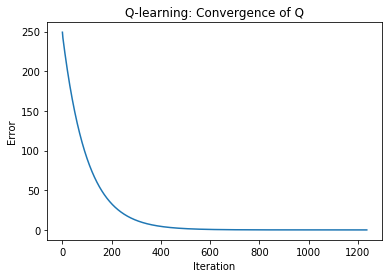

In [57]:
# --------------
# Point 3
# --------------
with open("./mvarl_hands_on/data/Q_opts.json", "r") as fp:
    Qopts = json.load(fp)
Qstar = Qopts["{}_{}".format(type(env).__name__,env.gamma)]
Q0 = np.random.rand(env.Ns, env.Na)
Q, greedy_policy, Q_history = value_iteration(Q0, env)

norm_values = [np.linalg.norm(Qstar - el, np.inf) for el in Q_history]

plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")

In [58]:
state = env.reset()
env.render()
for i in range(50):
    action = greedy_policy[state]
    state, reward, done, _ = env.step(action)
    env.render()

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : :_: : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+---------------

## Question 2: Q learning
Q learning is a model-free algorithm for estimating the optimal Q-function online.
It is an off-policy algorithm since the samples are collected with a policy that is (potentially) not the one associated to the estimated Q-function.

1. Implement Q learning with $\epsilon$-greedy exploration.
  - Plot the error in Q-functions over iterations
  - Plot the cumulative sum of rewards

In [0]:
# ---------------------------
# Q-Learning
# ---------------------------
# suggested interface
# you can change it!
class QLearning:

  def __init__(self, Q):
      self.Q = Q
  
  def sample_action(self, state, eps): 
    u = np.random.rand(1)[0]
    if(u > 1 - eps):
      return np.argmax(self.Q[state, :])
    else:
      return int(u * self.Q.shape[1]/(1 - eps))
      
  
  def update(self, state, action, next_state, reward, t, gamma, alpha):
      delta = reward + gamma*np.max(self.Q[next_state, :]) - self.Q[state, action]
      self.Q[state, action] = self.Q[state, action] + delta*alpha  

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
None
optimal policy:  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 3
 3 3 3 3 3 3 3 3 3 0 0]
est policy: [0 0 0 3 0 0 3 3 2 2 2 0 3 2 1 0 0 3 3 3 3 2 2 2 3 3 0 0 2 2 3 3 2 3 2 2 1
 3 3 3 3 3 3 3 3 3 2 0]


Text(0.5, 1.0, 'Q-learning: Convergence of Q')

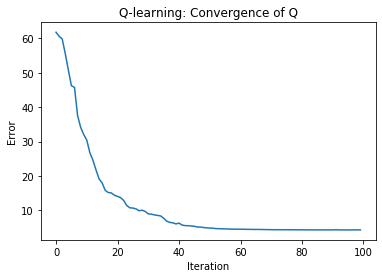

In [60]:
# --------------
# Point 1
# --------------
# Number of Q learning steps
max_steps = int(1e5)  
# max_steps = 10

Q0 = np.zeros((env.Ns, env.Na))
# Use the previous code to verify the correctness of q learning
Q_opt, pi_opt, _ = value_iteration(Q0, env, epsilon=1e-8)


# main algorithmic loop
norm_values = []
n = 100
eps = 0.3
ql = QLearning(Q0)
T = []
for i in range(n):
    nb_visit = np.zeros((env.Ns, env.Na))
    s0 = env.reset()
    done = False
    t = 1
    while t < max_steps and not done:
        T.append(t)
        action = ql.sample_action(s0, eps)
        observation, reward, done, info = env.step(action)
        s1 = observation
        nb_visit[s0, action] += 1
        alpha = 1/nb_visit[s0, action]
        ql.update(s0, action, s1, reward, t, env.gamma, alpha)
        s0 = s1
        t = t + 1
    norm_values.append(np.abs(ql.Q - Q_opt).mean())
    
print(env.render())
print("optimal policy: ", pi_opt)
greedy_policy = np.argmax(ql.Q, axis=1)
print("est policy:", greedy_policy)


plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")

# how confident are you in the performance of the algorithm? maybe a single run is not enough